In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import db_connection
import ast
import re

from mysql.connector import Error
from orgelpredigt_analysis import Sermon

import folium
import json
import os

In [2]:
id = "E000092"

In [3]:
cursor, connection = db_connection.get_connection()

In [4]:
for i in ["E100134", "E100194", "E100033"]:
    try:
        cursor.execute(f"SELECT e10id, e10komponist, e10werk, e10kurztitel, e10textdichter, e10gattung, e10besetzung FROM e10_musikwerke WHERE e10id = '{i}'")
        column_names = [col[0] for col in cursor.description]
        results = cursor.fetchall()
        print(results)
        if results:
            data = [dict(zip(column_names, row))  
                for row in results][0]
            print(data)
        else:
            print(f"Query executed for {i}, but no data found.")
    except Error as e:
        print(f"Database error occurred for {i}:", e)
    except Exception as e:
        print(f"Unexpected error for {i}:", e)



[('E100134', 'Anton, Christoph ; Hintze, Jacob', 'Alle Menschen müssen sterben', '', 'Albinus, Johann Georg ; Rosenmüller, Johann', 'Kirchenlied', '')]
{'e10id': 'E100134', 'e10komponist': 'Anton, Christoph ; Hintze, Jacob', 'e10werk': 'Alle Menschen müssen sterben', 'e10kurztitel': '', 'e10textdichter': 'Albinus, Johann Georg ; Rosenmüller, Johann', 'e10gattung': 'Kirchenlied', 'e10besetzung': ''}
[]
Query executed for E100194, but no data found.
[('E100033', 'Anonym', 'Ach Gott wie manches Herzeleid', '', 'Moller, Martin', 'Kirchenlied', '')]
{'e10id': 'E100033', 'e10komponist': 'Anonym', 'e10werk': 'Ach Gott wie manches Herzeleid', 'e10kurztitel': '', 'e10textdichter': 'Moller, Martin', 'e10gattung': 'Kirchenlied', 'e10besetzung': ''}


In [3]:
sermon = Sermon(id)

Query executed for E100155, but no data found.


In [18]:
rgb = 'rgb(135, 44, 162)'
rgb = rgb[4:-1]
rgb = tuple(int(x) for x in rgb.split(", "))
rgb

(135, 44, 162)

In [11]:
cursor.execute(f"SELECT * FROM e10_musikwerke WHERE e10id = 'E100155'")
#cursor.execute(f"SELECT e10id, e10komponist, e10werk, e10kurztitel, e10textdichter, e10gattung, e10besetzung FROM e10_musikwerke WHERE e10id = 'E100155'")
column_names = [col[0] for col in cursor.description]
results = cursor.fetchall()
results

[]

In [7]:
for i in sermon.literaturzitate:
    print(i["item"])

Praetorius, Michael: Syntagmatis Musici Michaelis Praetorii C. Tomus Primus (Wittenberg: 1615)
Calvisius, Seth: Exercitationes Musicae Duae (Leipzig: 1600)
Plutarch ; Xylander, Wilhelm (Hrsg.): Plutarchi Chaeronensis Moralia, Quae Usurpantur (Frankfurt: 1619)
Horatius Flaccus, Quintus ; Färber, Hans (Übersetzer): Sämtliche Werke (München ; Zürich: 1982)
Dieterich, Conrad: Vlmische Glocken Predigt (Ulm: 1625)
Prediger im Fürstenthumb Anhalt: Erinnerungs Schrifft etlicher vom Adel vnd Stedten An den Durchleuchtigen Hochgebornen Fuersten vnd Herrn Herrn Johann Georgen Fuersten zu Anhalt Graffen zu Ascanien HErrn zu Zerbst vnd Bernburg etc. (Zerbst: 1596)
Plutarch ; Bernardakis, Gregorius N. (Hrsg.): Plutarchi Chaeronensis Moralia (Leipzig: 1895)
Apollonius, Rhodius: ΑΠΟΛΛΩΝΙΟΥ ΤΟΥ ΡΟΔΙΟΥ ΑΡΓΟΝΑΥΤΙΚΑ (Frankfurt am Main: 1546)
Theodoretus: Beati Theodoreti Episcopi Cyrensis [...] opera omnia, quae ad hunc diem Latine versa sparsim extiterunt (Köln: 1617)
Hilarius [Pictaviensis] ; Gillot, Je

In [5]:
color_map = {
        'orgelpredigt': 'rgb(135, 44, 162)',
        'musikwerk': 'rgb(192, 54, 157)',
        'literatur': 'rgb(234, 79, 136)',
        'quelle': 'rgb(250, 120, 118)',
        'bibel': 'rgb(246, 169, 122)',
        'nan': 'rgb(237, 217, 163)',
        'text': 'rgb(237, 217, 163)'
    }

In [16]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
def generate_normalized_gradient(rgb, n):
    """
    Generate a list of `n` normalized RGB gradient values
    that fade from black to the input `rgb` color.

    Parameters:
        rgb (tuple): A tuple of 3 integers (R, G, B), each 0-255.
        n (int): Number of gradient steps.

    Returns:
        list of tuples: Each tuple contains normalized (R, G, B) values.
    """
    rgb = tuple(int(x) for x in rgb[4:-1].split(", "))
    print(rgb)
    if not (isinstance(rgb, tuple) and len(rgb) == 3 and all(0 <= val <= 255 for val in rgb)):
        raise ValueError("RGB must be a tuple of three integers between 0 and 255.")
    if n <= 0:
        raise ValueError("Number of gradient steps must be positive.")
    
    gradient = []
    for i in range(n):
        ratio = i / (n - 1) if n > 1 else 1
        r = (rgb[0] * ratio) / 255
        g = (rgb[1] * ratio) / 255
        b = (rgb[2] * ratio) / 255
        gradient.append((r, g, b))
    print(gradient)
    return gradient

lit_labels = []
lit_data = []
lit_titel = []
lit_wordshare = []
lit_wordfraction = []
orgel_labels = []
orgel_data = []
orgel_titel = []
orgel_wordshare = []
orgel_wordfraction = []
musik_labels = []
musik_data = []
musik_titel = []
musik_wordshare = []
musik_wordfraction = []
for quelle in sermon.literaturzitate:
    lit_titel.append(str(quelle["item"]))
    lit_wordshare.append(quelle["word_share"])
    lit_wordfraction.append(float("{:.4f}".format((quelle["word_share"]/len(sermon.words))*100)))
    lit_labels.append(str(quelle["item"]))
    lit_data.append(quelle["word_share"])
for predigt in sermon.orgelpredigtzitate:
    orgel_titel.append(str(predigt["item"]))
    orgel_wordshare.append(predigt["word_share"])
    orgel_wordfraction.append(float("{:.4f}".format((predigt["word_share"]/len(sermon.words))*100)))
    orgel_labels.append(str(predigt["item"]))
    orgel_data.append(predigt["word_share"])
for musik in sermon.musikzitate:
    musik_titel.append(str(musik["item"]))
    musik_wordshare.append(musik["word_share"])
    musik_wordfraction.append(float("{:.4f}".format((musik["word_share"]/len(sermon.words))*100)))
    musik_labels.append(str(musik["item"]))
    musik_data.append(musik["word_share"])


labels = []
values = []
colors = []
for item, broad_color in zip([[lit_labels, lit_data], [orgel_labels, orgel_data], [musik_labels, musik_data]], ['quelle', 'orgelpredigt', 'musikwerk']):
    print(item[0])
    #for x,y  in item[0], item[1]:
    labels += item[0]
    values += item[1]
    colors += generate_normalized_gradient(color_map[broad_color], len(labels))

quotations_piechart = go.Figure(go.Pie(values=values, 
                             labels=labels, 
                             marker=dict(colors=colors),
                             title='Verwendete Zitate'))

quotations_piechart.update_layout(
    width=700,
    height=700,
    margin=dict(t=80, b=50, l=50, r=50),
    title_x=0.5,  # Center title
    legend=dict(
        orientation="h",  # horizontal legend
        y=-0.1  # push legend below chart
    )
)

['Bale, John: Acta romanorum Pontificum (Basel: 1558)', 'Azpilcueta, Martín de: Enchiridion sive manuale de oratione et horis caononicis (Rom: 1578)', 'Augustinus, Aurelius ; Migne, Jacques Paul (Hrsg.): Sancti Aurelii Augustini, Hipponensis episcopi, opera omnia (Paris: 1865)', 'Luther, Martin: Der Fünffte Teil/ aller Buecher vnd Schrifften/ des thewren seligen Mans Gottes Docto[ris] Martini Lutheri (Jena: 1575/1577)', 'Sachs, Michael: Newe KeyserChronica (Magdeburg ; Braunschweig: [1643])', 'Luther, Martin ; Aurifaber, Johannes (Hrsg.): Colloquia, Oder, Christliche, nützliche Tischreden Doctoris Martini Lutheri (Jena: 1591)', 'Kircher, Conrad: Concordantiae Veteris Testamenti Graecae, Ebraeis Vocibus Respondentes (Frankfurt am Main: 1607)', 'Mathesius, Johannes: Historien/ Von des Ehrwirdigen inn Gott seligen theuren Manns Gottes/ D. Martin Luthers/ Anfang/ Lere/ Leben Stand|hafft bekentnuß seines Glaubens/ vnd Sterben (Nürnberg: 1576)', 'Jenisch, Paul: ValetPredigten/ Uber den Spruc

ValueError: 
    Invalid value of type 'builtins.list' received for the 'marker' property of pie
        Received value: [(0.0, 0.0, 0.0), (0.042625745950554135, 0.020460358056265986, 0.02011935208866155), (0.08525149190110827, 0.04092071611253197, 0.0402387041773231), (0.1278772378516624, 0.061381074168797956, 0.06035805626598465), (0.17050298380221654, 0.08184143222506395, 0.0804774083546462), (0.21312872975277067, 0.10230179028132992, 0.10059676044330775), (0.2557544757033248, 0.12276214833759591, 0.1207161125319693), (0.29838022165387895, 0.1432225063938619, 0.14083546462063087), (0.3410059676044331, 0.1636828644501279, 0.1609548167092924), (0.38363171355498726, 0.18414322250639387, 0.181074168797954), (0.42625745950554134, 0.20460358056265984, 0.2011935208866155), (0.4688832054560955, 0.22506393861892582, 0.22131287297527708), (0.5115089514066496, 0.24552429667519182, 0.2414322250639386), (0.5541346973572037, 0.26598465473145777, 0.26155157715260013), (0.5967604433077579, 0.2864450127877238, 0.28167092924126175), (0.639386189258312, 0.3069053708439898, 0.3017902813299233), (0.6820119352088662, 0.3273657289002558, 0.3219096334185848), (0.7246376811594202, 0.3478260869565217, 0.3420289855072463), (0.7672634271099745, 0.36828644501278773, 0.362148337595908), (0.8098891730605285, 0.38874680306905374, 0.3822676896845695), (0.8525149190110827, 0.4092071611253197, 0.402387041773231), (0.8951406649616368, 0.4296675191815857, 0.4225063938618926), (0.937766410912191, 0.45012787723785164, 0.44262574595055415), (0.9803921568627451, 0.47058823529411764, 0.4627450980392157), (0.0, 0.0, 0.0), (0.022058823529411766, 0.00718954248366013, 0.026470588235294117), (0.04411764705882353, 0.01437908496732026, 0.052941176470588235), (0.0661764705882353, 0.021568627450980392, 0.07941176470588235), (0.08823529411764706, 0.02875816993464052, 0.10588235294117647), (0.11029411764705882, 0.03594771241830066, 0.1323529411764706), (0.1323529411764706, 0.043137254901960784, 0.1588235294117647), (0.15441176470588236, 0.05032679738562092, 0.18529411764705883), (0.17647058823529413, 0.05751633986928104, 0.21176470588235294), (0.19852941176470587, 0.06470588235294118, 0.23823529411764705), (0.22058823529411764, 0.07189542483660132, 0.2647058823529412), (0.2426470588235294, 0.07908496732026143, 0.2911764705882353), (0.2647058823529412, 0.08627450980392157, 0.3176470588235294), (0.2867647058823529, 0.0934640522875817, 0.34411764705882353), (0.3088235294117647, 0.10065359477124183, 0.37058823529411766), (0.33088235294117646, 0.10784313725490197, 0.39705882352941174), (0.35294117647058826, 0.11503267973856209, 0.4235294117647059), (0.375, 0.12222222222222223, 0.45), (0.39705882352941174, 0.12941176470588237, 0.4764705882352941), (0.41911764705882354, 0.13660130718954247, 0.5029411764705882), (0.4411764705882353, 0.14379084967320263, 0.5294117647058824), (0.4632352941176471, 0.15098039215686274, 0.5558823529411765), (0.4852941176470588, 0.15816993464052287, 0.5823529411764706), (0.5073529411764706, 0.16535947712418303, 0.6088235294117647), (0.5294117647058824, 0.17254901960784313, 0.6352941176470588), (0.0, 0.0, 0.0), (0.023529411764705882, 0.006617647058823529, 0.019240196078431374), (0.047058823529411764, 0.013235294117647059, 0.03848039215686275), (0.07058823529411765, 0.019852941176470587, 0.05772058823529412), (0.09411764705882353, 0.026470588235294117, 0.0769607843137255), (0.11764705882352941, 0.03308823529411765, 0.09620098039215687), (0.1411764705882353, 0.039705882352941174, 0.11544117647058824), (0.16470588235294117, 0.04632352941176471, 0.1346813725490196), (0.18823529411764706, 0.052941176470588235, 0.153921568627451), (0.21176470588235294, 0.05955882352941176, 0.17316176470588235), (0.23529411764705882, 0.0661764705882353, 0.19240196078431374), (0.25882352941176473, 0.07279411764705883, 0.2116421568627451), (0.2823529411764706, 0.07941176470588235, 0.23088235294117648), (0.3058823529411765, 0.08602941176470588, 0.25012254901960784), (0.32941176470588235, 0.09264705882352942, 0.2693627450980392), (0.35294117647058826, 0.09926470588235294, 0.28860294117647056), (0.3764705882352941, 0.10588235294117647, 0.307843137254902), (0.4, 0.1125, 0.32708333333333334), (0.4235294117647059, 0.11911764705882352, 0.3463235294117647), (0.4470588235294118, 0.12573529411764706, 0.36556372549019606), (0.47058823529411764, 0.1323529411764706, 0.38480392156862747), (0.49411764705882355, 0.13897058823529412, 0.40404411764705883), (0.5176470588235295, 0.14558823529411766, 0.4232843137254902), (0.5411764705882353, 0.15220588235294116, 0.44252450980392155), (0.5647058823529412, 0.1588235294117647, 0.46176470588235297), (0.5882352941176471, 0.16544117647058823, 0.4810049019607843), (0.611764705882353, 0.17205882352941176, 0.5002450980392157), (0.6352941176470588, 0.1786764705882353, 0.5194852941176471), (0.6588235294117647, 0.18529411764705883, 0.5387254901960784), (0.6823529411764706, 0.19191176470588237, 0.5579656862745098), (0.7058823529411765, 0.19852941176470587, 0.5772058823529411), (0.7294117647058823, 0.2051470588235294, 0.5964460784313725), (0.7529411764705882, 0.21176470588235294, 0.615686274509804)]

    The 'marker' property is an instance of Marker
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.pie.Marker`
      - A dict of string/value properties that will be passed
        to the Marker constructor

In [9]:
x = (set([x for xs in sermon.reference for x in xs]))
for i in x:
    print(i)

2Kön_3-11.12.13.14.15.16.17.18.19
Am_3-6
Num_10-10
2Chr_8-14
2Sam_6-15
Ps_98
1Sam_16-14.15.16.17.18.19.20.21.22.23
Ps_81-2
Offb_14-2.3
E080508
Dtn_10-17
Ps_33
E090600
1Kor_14-15
1Chr_24-5
Offb_5-8
1Chr_26-1.7
E080222
E080282
Ps_150-1
1Chr_26.1
2Sam_6-5
Ex_20-24
1Kor_13-1
Ps_96
E080406
Dtn_4-35
Gen_4-21
E090816
E080524
Ps_150-2
Joh_3-29
Ps_149
E080407
Ps_150-6
E080380
E080512
E080517
Jes_64-4
Esra_2-65
Lk_11-20
E080313
E090810
1Sam_16-23
Esra_2-41
Am_5-23
Eph_5-19
Ps_89-9
Ps_81-3.4.5
Ps_81-5
2Chr_5-12
E080378
2Kön_3-15
Offb_1-4
E080183
Ps_57-9
E080223
1Kor_14-7
Ex_15-20
E080518
Ps_150
Offb_15-3
1Kor_14-40
Ps_150-1.2
E080523
E080528
Ps_150-1.2.3.4.5.6
E080522
Ps_81
1Chr_26-7
Ps_150-3.4.5
1Kor_2-9
Dtn_6-4
E080525
E090815
E090560
2Chr_7-6


In [6]:
str(sermon.einweihungsort)

'Ulm, Münster ; E030003'

In [7]:
cursor, connection = db_connection.get_connection()

In [8]:
def is_id(value):
    pattern = re.compile(r'E[01][0-9]{5}')
    if re.match(pattern, value):
        return True
    else:
        return False

In [9]:
def parse_coords(coord_str):
    try:
        if not coord_str:
            return None
        parts = coord_str.split(';')
        if len(parts) != 2:
            return None
        lon_str = parts[0].strip()
        lat_str = parts[1].strip()
        if lon_str[0] != 'E' or lat_str[0] != 'N':
            return None
        lon = float(lon_str[1:])
        lat = float(lat_str[1:])
        return lat, lon
    except:
        return None

In [10]:
str(sermon.verleger)

'Meder'

In [11]:
import streamlit as st
from streamlit_folium import st_folium

2025-06-23 19:38:52.650 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [12]:
author_network = sermon.autor.get_personal_network()

In [13]:
sermon_locations = {
    sermon.einweihungsort.name : sermon.einweihungsort.koordinaten,
    sermon.verlagsort.name : sermon.verlagsort.koordinaten
}

In [14]:
# create folium Map
map = folium.Map(location=[50.8, 8.7], zoom_start=10)

In [ ]:
# Add markers
for place, coord_str in author_network.items():
    coords = parse_coords(coord_str)
    if coords:
        folium.Marker(location=coords, popup=place, icon=folium.Icon(color='blue', icon='glyphicon-user')).add_to(map)

for place, coord_str in sermon_locations.items():
    coords = parse_coords(coord_str)
    if coords:
        folium.Marker(location=coords, popup=place, icon=folium.Icon(color='red', icon='glyphicon-book')).add_to(map)

map

In [15]:
import plotly.express as px
import math
import pandas

In [15]:
labels

[' bibel', ' quelle', ' bibel quelle', ' quelle literatur', ' literatur', nan]

In [16]:
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    if pandas.isnull(label):
    #if math.isnan(int(label)):
        labels.append("text")
    else:
        labels.append(label.strip())
    data.append(number)

fig = px.pie(values=data, names=labels, title='My Pie Chart')
fig.show()

In [17]:
all_refs = sum(sermon.reference, [])
all_refs

['Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.

In [18]:
len(sermon.words)

10844

In [4]:
for quelle in sermon.literaturzitate:
    print(str(quelle["item"]), quelle["word_share"])

NameError: name 'sermon' is not defined

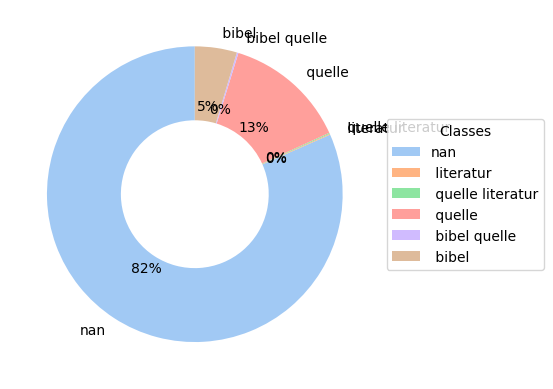

In [20]:
# plotting data on chart
occurrences = {i:sermon.word_types.count(i) for i in set(sermon.word_types)}

labels = []
data = []
for label, number in occurrences.items():
    labels.append(label)
    data.append(number)

colors = sns.color_palette('pastel')

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    data,
    labels=labels,
    colors=colors,
    startangle=90,
    autopct='%.0f%%',
    wedgeprops=dict(width=0.5)
)

ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


In [21]:
from pprint import pprint

In [22]:
def generate_quotation_text(words, labels, references):
    text = '<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="UTF-8">\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<title>HTML 5 Boilerplate</title><link rel="stylesheet" href="style.css"></head><body><p>'
    for word, label, ref in zip(words, labels, str(references)):
        text += f'<span class="{label}" ref="{ref}">{word}</span> '
    text += '</p></body></html>'
    return text

In [25]:
labels = sermon.word_types

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

pprint(list(chunks(range(10, 75), 10)))


[range(10, 20),
 range(20, 30),
 range(30, 40),
 range(40, 50),
 range(50, 60),
 range(60, 70),
 range(70, 75)]


In [136]:
literaturliste = ""
lit_labels = []
lit_data = []
lit_titel = []
lit_wordshare = []
lit_wordfraction = []
for quelle in sermon.literaturzitate:
    lit_titel.append(str(quelle["item"]))
    lit_wordshare.append(quelle["word_share"])
    lit_wordfraction.append("{:.4f}%".format((quelle["word_share"]/len(sermon.words))*100))
    lit_labels.append(str(quelle["item"]))
    lit_data.append(quelle["word_share"])

In [137]:
literatur = pd.DataFrame(
    {'Titel': lit_titel,
     'Länge': lit_wordshare,
     'Anteil': lit_wordfraction
    })
literatur

,Titel,Länge,Anteil
0,"Praetorius, Michael: Syntagmatis Musici Michae...",232,2.1394%
1,"Erasmus, Desiderius ; Manuzio, Paolo (Hrsg.): ...",50,0.4611%
2,"Hilarius [Pictaviensis] ; Gillot, Jean: Sancti...",65,0.5994%
3,"Justinus Martyr: Divi Ivstini, Philosophi Ac M...",15,0.1383%
4,Universität Wittenberg: Notwendige Antwort/ Au...,160,1.4755%
5,Universität Wittenberg: Notwendige Antwort/ Au...,160,1.4755%
6,"Schweigger, Salomon: Ein newe Reyßbeschreibung...",2,0.0184%
7,"Calvisius, Seth: Exercitationes Musicae Duae (...",212,1.9550%
8,Prediger im Fürstenthumb Anhalt: Erinnerungs S...,10,0.0922%
9,"Plutarch ; Xylander, Wilhelm (Hrsg.): Plutarch...",4,0.0369%


In [ ]:


custom_labels = [
    f"{label}: {value / len(sermon.words) * 100:.1f}%" if (value / len(sermon.words) * 100) > 5 else ''
    for label, value in zip(lit_labels, lit_data)
]

fig2 = px.pie(values=lit_data, names=lit_labels, title='Verwendete Zitate')



fig2.update_layout(
    width=700,
    height=700,
    margin=dict(t=80, b=50, l=50, r=50),
    title_x=0.5,  # Center title
    legend=dict(
        orientation="h",  # horizontal legend
        y=-0.1  # push legend below chart
    )
)

fig2.show()

In [22]:
len(sermon.words)

10844

In [28]:
overhang = len(sermon.words) % 100
-overhang

-44

In [ ]:
quote_distribution_chunked = go.Figure(layout=dict(barmode='stack'))

for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        quote_distribution_chunked.add_trace(go.Bar(
            name=str(key).strip(), 
            x=[bar_title], 
            y=[val],
            marker_color=color_map.get(str(key).strip(), 'gray')
            ))

quote_distribution_chunked.update_layout(barmode='stack')

In [40]:
from collections import Counter
import plotly.graph_objects as go

In [68]:
types = ["" if isinstance(x, float) else x for x in sermon.word_types[i:i+100]]
reference = [" ".join(ref) for ref in sermon.reference[400:500]]
lst = list(zip(types, reference))
print(lst[0])
print(" ".join(lst[0]))
concat = [",".join(zipped) for zipped in list(zip(types, reference))]
print(concat)

(' bibel', '')
 bibel 
[' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ' bibel,Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6', ',Ps_150-1.2.3.4.5.6']


In [112]:
##### quotation distribution over sermon in 100-Word-Chunks
overhang = len(sermon.words) % 100 
chunked_types=[]
for i in range(0,len(sermon.words),100):
    types = ["text" if isinstance(x, float) else x for x in sermon.word_types[i:i+100]]
    reference = [" ".join(ref) for ref in sermon.reference[i:i+100]]
    concat = [",".join(zipped) for zipped in list(zip(types, reference))]
    chunked_types.append(concat)

last_types = ["" if isinstance(x, float) else x for x in sermon.word_types[-overhang:]]
last_refs = [" ".join(ref) for ref in sermon.reference[-overhang:]]
last_concat = [",".join(zipped) for zipped in list(zip(last_types, last_refs))]
chunked_types.append(last_types)

In [113]:
Counter(chunked_types[21])

Counter({' quelle,E080512': 75,
         'text,': 13,
         ' quelle literatur,E080512 E090810': 12})

In [114]:
Counter(chunked_types[21])

Counter({' quelle,E080512': 75,
         'text,': 13,
         ' quelle literatur,E080512 E090810': 12})

In [115]:

for i in chunked_types:
    for key, value in dict(Counter(i)).items():
        print(key.strip(), value)

text, 100
text, 100
text, 100
text, 100
text, 31
bibel,Ps_150-1.2.3.4.5.6 69
text, 100
text, 97
quelle,E080508 3
text, 100
text, 82
bibel,Dtn_6-4 8
bibel,Dtn_10-17 8
bibel,Dtn_4-35 2
text, 76
bibel,Ps_89-9 9
bibel,Ps_81-2 5
bibel,Ps_150-1.2 10
bibel,Ps_150-1.2 2
text, 92
bibel,Ps_150-2 6
text, 68
bibel,Ps_150-3.4.5 32
text, 66
quelle,E080222 34
quelle,E080222 14
text, 86
text, 100
text, 100
text, 94
bibel,Ps_150-1 6
text, 86
bibel,Ex_20-24 7
bibel,Ps_150-6 7
text, 100
text, 100
text, 100
text, 13
quelle,E080512 75
quelle literatur,E080512 E090810 12
quelle,E080512 68
text, 30
bibel,Gen_4-21 2
text, 100
text, 96
bibel,Ex_15-20 4
text, 59
bibel,Num_10-10 17
bibel,Ps_81-3.4.5 20
bibel,Ps_81-5 4
text, 89
bibel,2Sam_6-15 4
bibel,1Chr_24-5 4
bibel,1Chr_26.1 3
text, 74
bibel,1Chr_26-1.7 5
quelle,E080282 18
bibel,1Chr_26-7 3
bibel,1Chr_26-7 1
text, 92
bibel,Ps_150 1
bibel,Ps_33 1
bibel,Ps_81 1
bibel,Ps_96 1
bibel,Ps_98 1
bibel,Ps_149 2
text, 58
bibel,2Chr_5-12 19
bibel,2Chr_7-6 4
bibel,2Chr_8-

In [116]:
fig = go.Figure(layout=dict(barmode='stack'))

In [117]:
overhang = len(sermon.words) % 100

In [118]:
color_map = {
    'nan': 'steelblue',
    'bibel': 'tomato',
    'text': 'steelblue',
    'quelle': 'limegreen',
    'literatur': 'teal',
    'musikwerk': 'lavenderblush'
}

In [119]:
for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        print(bar_title, key, val)

Wörter 1 bis 100 text, 100
Wörter 200 bis 300 text, 100
Wörter 300 bis 400 text, 100
Wörter 400 bis 500 text, 100
Wörter 500 bis 600 text, 31
Wörter 500 bis 600  bibel,Ps_150-1.2.3.4.5.6 69
Wörter 600 bis 700 text, 100
Wörter 700 bis 800 text, 97
Wörter 700 bis 800  quelle,E080508 3
Wörter 800 bis 900 text, 100
Wörter 900 bis 1000 text, 82
Wörter 900 bis 1000  bibel,Dtn_6-4 8
Wörter 900 bis 1000  bibel,Dtn_10-17 8
Wörter 900 bis 1000  bibel,Dtn_4-35 2
Wörter 1000 bis 1100 text, 76
Wörter 1000 bis 1100  bibel,Ps_89-9 9
Wörter 1000 bis 1100  bibel,Ps_81-2 5
Wörter 1000 bis 1100  bibel,Ps_150-1.2 10
Wörter 1100 bis 1200  bibel,Ps_150-1.2 2
Wörter 1100 bis 1200 text, 92
Wörter 1100 bis 1200  bibel,Ps_150-2 6
Wörter 1200 bis 1300 text, 68
Wörter 1200 bis 1300  bibel,Ps_150-3.4.5 32
Wörter 1300 bis 1400 text, 66
Wörter 1300 bis 1400  quelle,E080222 34
Wörter 1400 bis 1500  quelle,E080222 14
Wörter 1400 bis 1500 text, 86
Wörter 1500 bis 1600 text, 100
Wörter 1600 bis 1700 text, 100
Wörter 170

In [120]:
for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        print(key)
        color, ref = key.split(',')
        print(bar_title, ref, color, val)

text,
Wörter 1 bis 100  text 100
text,
Wörter 200 bis 300  text 100
text,
Wörter 300 bis 400  text 100
text,
Wörter 400 bis 500  text 100
text,
Wörter 500 bis 600  text 31
 bibel,Ps_150-1.2.3.4.5.6
Wörter 500 bis 600 Ps_150-1.2.3.4.5.6  bibel 69
text,
Wörter 600 bis 700  text 100
text,
Wörter 700 bis 800  text 97
 quelle,E080508
Wörter 700 bis 800 E080508  quelle 3
text,
Wörter 800 bis 900  text 100
text,
Wörter 900 bis 1000  text 82
 bibel,Dtn_6-4
Wörter 900 bis 1000 Dtn_6-4  bibel 8
 bibel,Dtn_10-17
Wörter 900 bis 1000 Dtn_10-17  bibel 8
 bibel,Dtn_4-35
Wörter 900 bis 1000 Dtn_4-35  bibel 2
text,
Wörter 1000 bis 1100  text 76
 bibel,Ps_89-9
Wörter 1000 bis 1100 Ps_89-9  bibel 9
 bibel,Ps_81-2
Wörter 1000 bis 1100 Ps_81-2  bibel 5
 bibel,Ps_150-1.2
Wörter 1000 bis 1100 Ps_150-1.2  bibel 10
 bibel,Ps_150-1.2
Wörter 1100 bis 1200 Ps_150-1.2  bibel 2
text,
Wörter 1100 bis 1200  text 92
 bibel,Ps_150-2
Wörter 1100 bis 1200 Ps_150-2  bibel 6
text,
Wörter 1200 bis 1300  text 68
 bibel,Ps_15

In [124]:
fig = go.Figure(layout=dict(barmode='stack'))

for row, nr in zip(chunked_types, range(1, len(chunked_types))):
    item = dict(Counter(row))
    bar_title = f"Wörter 1 bis 100" if nr == 1 else f"Wörter {nr * 100} bis {(nr * 100) +100}"
    for key, val in item.items():
        color, ref = key.split(',')
        fig.add_trace(go.Bar(
            name=("https://orgelpredigt.ur.de/"+ str(ref).strip()) if is_id(ref) else str(key)[:-1].strip(), 
            x=[bar_title], 
            y=[val],
            marker_color=color_map.get(str(color).strip(), 'gray')
            ))

fig.update_layout(barmode='stack')

fig.show()

In [65]:
for counter, i in zip(range(0,len(sermon.words),100), chunked_types):
    bar = str(counter)
    for label, number in dict(Counter(i)).items():
        print(bar, label, number)
        fig.add_trace(go.Bar(
            name=label,
            x=[bar],
            y=[number]
        ))

0 nan 100
100 nan 100
200 nan 100
300 nan 100
400 nan 31
400  bibel 69
500 nan 100
600 nan 97
600  quelle 3
700 nan 100
800 nan 82
800  bibel 18
900 nan 76
900  bibel 24
1000  bibel 8
1000 nan 92
1100 nan 68
1100  bibel 32
1200 nan 66
1200  quelle 34
1300  quelle 14
1300 nan 86
1400 nan 100
1500 nan 100
1600 nan 94
1600  bibel 6
1700 nan 86
1700  bibel 14
1800 nan 100
1900 nan 100
2000 nan 100
2100 nan 13
2100  quelle 75
2100  quelle literatur 12
2200  quelle 68
2200 nan 30
2200  bibel 2
2300 nan 100
2400 nan 96
2400  bibel 4
2500 nan 59
2500  bibel 41
2600 nan 89
2600  bibel 11
2700 nan 74
2700  bibel 8
2700  quelle 18
2800  bibel 8
2800 nan 92
2900 nan 58
2900  bibel 27
2900  quelle 15
3000  quelle 23
3000  bibel quelle 5
3000 nan 60
3000  bibel 12
3100 nan 96
3100  bibel 4
3200 nan 69
3200  quelle 30
3200  literatur 1
3300  literatur 1
3300 nan 60
3300  quelle 39
3400  quelle 65
3400 nan 35
3500  quelle 2
3500 nan 73
3500  bibel 25
3600 nan 93
3600  bibel 7
3700 nan 24
3700  bibel 3

In [66]:
fig.update_layout(barmode='stack')

fig.show()

In [143]:
cursor.execute(f"SELECT e00id, e00kurztitel, e00jahr FROM e00_orgelpredigten")
results = cursor.fetchall()
print(results)

[('E000001', 'Christliche Predigt (Tübingen 1602)', '1602'), ('E000002', 'Musica instrumentalis (Meißen 1605)', '1605'), ('E000003', 'Vlmische Orgel Predigt (Ulm 1624)', '1624'), ('E000004', 'Vlmische Orgel Predigt (Ulm / Frankfurt a. M. 1625)', '1625'), ('E000005', 'Kirchweih= oder Orgel=Predigt (Leipzig 1632)', '1632'), ('E000006', 'Eine Predigt bey der Einweihung der neuerbauten Orgel (Magdeburg 1798)', '1798'), ('E000007', 'Predigt bey der feyerlichen Einweihung der neuen Orgel (Magdeburg 1798)', '1798'), ('E000008', 'Predigt Bey der Einweihung einer Orgel (Leipzig 1797)', '1797'), ('E000009', 'Predigt bey Einweyhung der Orgel (s.l. 1795)', '1795'), ('E000010', 'Ermunterung den öffentlichen Gottesdienst in Ehren zu halten (Frankfurt an der Oder s.a.)', '1789 [s.a.]'), ('E000011', 'Die grossen Vortheile eines wohlgeordneten Kirchengesangs', '1785'), ('E000012', 'Predigt bey der Einweihung der neuerbaueten Orgel (Halle 1784)', '1784'), ('E000013', 'Predigt bey Einweihung einer neuen 

In [162]:
predigten_übersicht = {}
for i in results:
    a = {}
    a["title"] = i[1]
    a["year"] = i[2]
    predigten_übersicht[i[0]] = a

In [163]:
path = 'sermon_tables/'
files = [file[:-4] for file in os.listdir(path)]

In [164]:
files

['E000039',
 'E000072',
 'E000030',
 'E000024',
 'E000038',
 'E000041',
 'E000053',
 'E000036',
 'E000023',
 'E000099',
 'E000092',
 'E000078',
 'E000073',
 'E000098',
 'E000079',
 'E000020',
 'E000104',
 'E000065',
 'E000070',
 'E000091',
 'E000109',
 'E000060',
 'E000059',
 'E000048',
 'E000089',
 'E000035',
 'E000057',
 'E000045',
 'E000069',
 'E000014',
 'E000042',
 'E000090',
 'E000007',
 'E000075',
 'E000015',
 'E000001',
 'E000074',
 'E000082',
 'E000037',
 'E000029',
 'E000106',
 'E000009',
 'E000061',
 'E000008',
 'E000027',
 'E000108',
 'E000003',
 'E000055',
 'E000052',
 'E000067',
 'E000085',
 'E000058',
 'E000083',
 'E000095',
 'E000034',
 'E000096',
 'E000046',
 'E000016',
 'E000051',
 'E000002',
 'E000068',
 'E000056',
 'E000086',
 'E000063',
 'E000021']

In [165]:
for i in files:
    if i not in predigten_übersicht:
        print(i)
        del predigten_übersicht[i]

In [166]:
print(predigten_übersicht)

{'E000001': {'title': 'Christliche Predigt (Tübingen 1602)', 'year': '1602'}, 'E000002': {'title': 'Musica instrumentalis (Meißen 1605)', 'year': '1605'}, 'E000003': {'title': 'Vlmische Orgel Predigt (Ulm 1624)', 'year': '1624'}, 'E000004': {'title': 'Vlmische Orgel Predigt (Ulm / Frankfurt a. M. 1625)', 'year': '1625'}, 'E000005': {'title': 'Kirchweih= oder Orgel=Predigt (Leipzig 1632)', 'year': '1632'}, 'E000006': {'title': 'Eine Predigt bey der Einweihung der neuerbauten Orgel (Magdeburg 1798)', 'year': '1798'}, 'E000007': {'title': 'Predigt bey der feyerlichen Einweihung der neuen Orgel (Magdeburg 1798)', 'year': '1798'}, 'E000008': {'title': 'Predigt Bey der Einweihung einer Orgel (Leipzig 1797)', 'year': '1797'}, 'E000009': {'title': 'Predigt bey Einweyhung der Orgel (s.l. 1795)', 'year': '1795'}, 'E000010': {'title': 'Ermunterung den öffentlichen Gottesdienst in Ehren zu halten (Frankfurt an der Oder s.a.)', 'year': '1789 [s.a.]'}, 'E000011': {'title': 'Die grossen Vortheile ein

In [167]:
predigten_übersicht = {k: v for k, v in predigten_übersicht.items() if k in files}

In [176]:
with open("predigten_übersicht.json", "w") as file: 
    json.dump(predigten_übersicht, file, ensure_ascii=False, indent=2)

In [180]:
with open("predigten_übersicht.json", "r", encoding="utf-8") as file: 
    data = json.load(file)

In [184]:
data['E000001']['year']

'1602'

In [186]:
# Ensure all entries have a 'year' key
cleaned = {k: v for k, v in data.items() if 'year' in v}

year_finder = re.compile(r'[0-9]{4}')

for k, v in data.items():
    year = re.findall(year_finder, v['year'])[0]
    if year:
        v['year'] = year
    else:
        v['year'] = '[s.a.]'

# Convert to nested list and sort by year
relevant_sermons = sorted(
    [[key, value['title'], int(value['year'])] for key, value in cleaned.items()],
    key=lambda x: x[2]
)

print(relevant_sermons)


[['E000001', 'Christliche Predigt (Tübingen 1602)', 1602], ['E000002', 'Musica instrumentalis (Meißen 1605)', 1605], ['E000029', 'Christliche Predigt (Tübingen 1606)', 1606], ['E000030', 'Elogium Organi Musici (Altenburg 1610)', 1610], ['E000099', 'Corona Templi (Nürnberg 1621)', 1621], ['E000003', 'Vlmische Orgel Predigt (Ulm 1624)', 1624], ['E000098', 'Musica ecclesiastica (Stettin 1628)', 1628], ['E000096', 'Kostbare Bosische Orgel (Zwickau 1647)', 1647], ['E000095', 'Längst=gewüntzschte Mittweidische Orgel=Freude (Dresden 1648)', 1648], ['E000092', 'Organologismos (Dresden 1651)', 1651], ['E000091', 'Stolpenische Ehren-Crone (Dresden 1652)', 1652], ['E000090', 'Organolustria Evangelico-Stambachiana (Hof 1660)', 1660], ['E000089', 'Encoenia HierOrganica (Halle 1664)', 1664], ['E000086', 'Orgel=Predigt (Arnstadt 1666)', 1666], ['E000085', 'Das fröliche Hallelujah (Halle 1667)', 1667], ['E000083', 'Das Gott=Lob=Schallende Hosianna (Leipzig 1671)', 1671], ['E000082', 'Geistliches Orgel

In [188]:
x = "Christliche Predigt (Tübingen 1602) -- E000001"
print(x[-7:])

E000001


In [9]:
sermon.reference
reference = [x for xs in sermon.reference for x in xs]
reference


['Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.2.3.4.5.6',
 'Ps_150-1.

In [12]:

unique_refs = set(reference)
for i in unique_refs:
    print(i)

1Chr_24-5
Ps_150-3.4.5
Joh_3-29
E090560
Ps_150
E080524
1Chr_26-1.7
Eph_5-19
Ex_20-24
Ps_81-2
E080528
Gen_4-21
Lk_11-20
Offb_1-4
2Chr_7-6
E080313
Jes_64-4
Ps_149
2Sam_6-15
Ps_150-2
E080525
E090816
1Chr_26-7
2Chr_5-12
E080523
1Sam_16-23
2Chr_8-14
Num_10-10
E090600
Dtn_6-4
Esra_2-41
E080518
Esra_2-65
E080380
Dtn_4-35
Ps_98
Ps_81-3.4.5
Ex_15-20
Ps_96
1Kor_14-15
E080508
E080378
2Kön_3-15
1Kor_13-1
E080222
E080223
E080406
Ps_33
Ps_57-9
E080512
Ps_89-9
Am_3-6
Ps_150-1.2
2Kön_3-11.12.13.14.15.16.17.18.19
E080282
Offb_15-3
E080407
1Chr_26.1
1Sam_16-14.15.16.17.18.19.20.21.22.23
E080517
1Kor_14-40
Ps_81-5
E080522
Am_5-23
Offb_14-2.3
2Sam_6-5
Offb_5-8
Ps_81
E080183
Ps_150-1.2.3.4.5.6
Dtn_10-17
E090810
E090815
Ps_150-1
1Kor_2-9
1Kor_14-7
Ps_150-6


In [11]:
for x in sermon.literaturzitate:
    print(str(x["item"]))